# Linear Regression

In [1]:
%matplotlib inline

import warnings
import numpy as np
from numpy import log, exp, sqrt, pi, e

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
warnings.simplefilter('ignore')

## Random linear data

We will be fitting linear data in the form of a linear line with Gaussian noise added to the output.

$$
y = m x + b + \epsilon
$$

With:
- $y$ the independent (output) variable
- $x$ the dependent (input) variable
- $m$ the slope of the line
- $b$ the bias (or intercept) of the line
- $\epsilon$ the noise (disturbance)

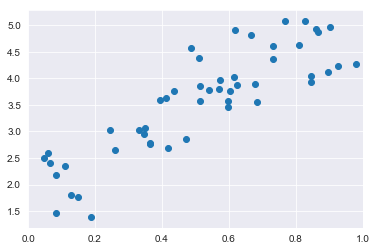

In [2]:
np.random.seed(4)
# Generate random data
n = 50 # Number of samples
# Underlying linear relation
m = 3  # slope
b = 2  # bias
# Noise
e_std = 0.5  # Standard deviation the of noise
err = e_std * np.random.randn(n)  # Noise
# Features and output
x = np.random.uniform(0, 1, n)  # Dependent variable x
y = x * m + b + err  # Independent variable

plt.scatter(x,y)
plt.xlim((0, 1))
plt.show()

## Linear regression problem description


### Simple linear regression
[Simple linear regression](https://en.wikipedia.org/wiki/Simple_linear_regression) will try to fit a linear relationship between a dependent variable $x$ (input) and an independent variable $y$ (output).

For $n$ data samples the linear relationship can be modelled as:

$$
y_i = \theta_0 + \theta_1 x_i + \epsilon_i  \quad (i = 1, \ldots, n)
$$

With:
- $x_i$ the dependent variable of sample $i$, with $x = \{x_i \ldots x_n \}$.
- $y_i$ the independent variable of sample $i$, with $y = \{y_i \ldots y_n \}$.
- $\theta_0$ the intercept (bias) of the model
- $\theta_1$ the coefficient of variable $x$
- $\theta = \{\theta_0, \theta_1 \}$ the set of the variables we're interested in.
- $\epsilon_i \sim \mathcal{N}(0, \sigma^2)$ [Gaussian noise](https://en.wikipedia.org/wiki/Normal_distribution) affecting the output $y_i$, with $\epsilon = {\epsilon_i \ldots \epsilon_n}$.


### Bayesian linear regression

An alternative description is the [Bayesian](https://en.wikipedia.org/wiki/Bayesian_inference) description of the linear regression problem where we treat the independent variable $y$ as randomly sampled from a normal distribution with a mean in function of the dependent variable $x$ and random variables $\theta$.

$$
y_i \sim \mathcal{N}(\theta_0 + \theta_1 x_i, \sigma^2) \quad (i = 1, \ldots, n)
$$

Given the observed data $x, y$ we can then model the parameters $\theta$ as a probability distribution which we can split up according to the [Bayes rule](https://en.wikipedia.org/wiki/Bayes%27_theorem):

$$
p(\theta \mid y, x) = \frac{p(y, x \mid \theta)p(\theta)}{p(y, x)}
$$

With:
- $P(\theta \mid y, x$ the [posterior](https://en.wikipedia.org/wiki/Posterior_probability) distribution which is the probability of parameters $\theta$ given the observed data $x, y$.
- $p(y, x \mid \theta)$ is the [likelihood](https://en.wikipedia.org/wiki/Likelihood_function) which is the probability of observing $x,y$ given parameters $\theta$.
- $p(\theta)$ is the [prior](https://en.wikipedia.org/wiki/Prior_probability) distibution of $\theta$ which captures our believe about parameters $\theta$ before we observed any data.
- $p(y, x)$ is the [marginal likelihood](https://en.wikipedia.org/wiki/Marginal_likelihood) of observing $x,y$ where $\theta$ has been [marginalized out](https://en.wikipedia.org/wiki/Marginal_distribution). $p(y, x) = \int_{\theta} p(y,x | \theta) p(\theta) d\theta$.

Note that the error $\epsilon$ is implicitly captured in this model by treating $y$ as sampled from a random distribution.


We can find a point estimate to fit our parameters $\theta$ by finding the maximum of the posterior distribution $\underset{\theta}{\text{argmax}}\;p(\theta \mid y, x)$. This is also known as [maximum a posteriori (MAP)](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) estimate.

In practice most algorithms to fit the parameters $\theta$ will try to avoid computing the marginal likelihood $p(y, x)$, which can be computational expensive due to the integral. Some of the algorithms will ignore the prior $p(\theta)$ for simplicity. In what follows we will describe 4 different algorithms that are used in practices to fit a linear regression model.

Note that below we will ignore fitting of the variance term $\sigma^2$ for practical purposes.

## Maximum likelihood for simple linear regression

If we want to maximize the posterior directly we have:


$$
\underset{\theta}{\text{argmax}}\;p(\theta \mid y, x) = \underset{\theta}{\text{argmax}}\; \frac{p(y, x \mid \theta)p(\theta)}{p(y, x)}
$$

Since the marginal likelihood $p(y, x)$ is independent of the parameters $\theta$ and won't have an effect on the maximum of the posterior we can write this as:

$$
\underset{\theta}{\text{argmax}}\;p(\theta \mid y, x) = \underset{\theta}{\text{argmax}}\; p(y, x \mid \theta)p(\theta)
$$

We can simplify this even more by ignoring the prior term $p(\theta)$ an treating it as an uninformative and improper prior:

$$
\underset{\theta}{\text{argmax}}\;p(\theta \mid y, x) \approx \underset{\theta}{\text{argmax}}\; p(y, x \mid \theta)
$$

The resulting optimization is what is known as [maximum likelihood estimation (MLE)](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation), which will focus only on the [likelihood function](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) $p(y, x \mid \theta)$ while ignoring the prior and marginal term completely.

If we assume that all samples $y,x$ are taken independently from the [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) $\mathcal{N}(\theta_0 + \theta_1 x_i, \sigma^2)$ we can write the [probability density](https://en.wikipedia.org/wiki/Probability_density_function) of $x, y$ given $\theta_0, \theta_1$ based on the definition of the normal distribution's density function:

$$
p(y, x \mid \theta_0, \theta_1) = \prod_{i=1}^{n} p(y_i, x_i \mid \theta_0, \theta_1) = \prod_{i=1}^{n} \frac{1}{\sqrt{2\pi\sigma^2}} e^{\textstyle \left( -\frac{(y_i - (\theta_0 + \theta_1 x_i))^2}{2\sigma^2}\right)}
$$


### Maximizing log-likelihood

Now we will try to find the estimated parameters $\hat{\theta}_0$ and $\hat{\theta}_1$ corresponding to the maximum of the likelihood function $p(y, x \mid \theta_0, \theta_1)$

Because the exponents of the density function are a difficult to work with we will transform the function with a [logarithmic function](https://en.wikipedia.org/wiki/Logarithm) which is [strictly increasing](https://en.wikipedia.org/wiki/Monotonic_function) and will thus not affect the maxima of the original likelihood function. We call the resulting function the log-likelihood:

$$
\log(\prod_{i=1}^{n} p(y_i, x_i \mid \theta_0, \theta_1)) = n(1 - \log(\sqrt{2\pi\sigma^2}) - \frac{1}{2\sigma^2} \left[ \sum_{i=1}^{n} (y_i - (\theta_0 + \theta_1 x_i))^2 \right]
$$

We can then find the [maximum](https://en.wikipedia.org/wiki/Maxima_and_minima) for this function by finding where the derivative of this function with repsect to its parameters becomes 0. If we work this out we find that:

$$
\hat{\theta}_1 = \frac{\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^{n}(x_i - \bar{x})^2} \\
\hat{\theta}_0 = \bar{y} - \hat{\theta}_1 \bar{x}
$$

with $\bar{y}$ the mean of all independent variables $y$ and $\bar{x}$ the mean of all dependent variables $x$.

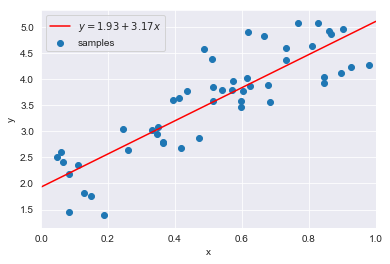

In [3]:
# Implementation of maximum likelihood for simple linear regression
x_mean = np.mean(x)
y_mean = np.mean(y)

theta_1 = sum((x[i]-x_mean)*(y[i]-y_mean) for i in range(n)
            ) / sum((x[i]-x_mean)**2 for i in range(n))
theta_0 = y_mean - theta_1 * x_mean
# Function representing fitted line
f = lambda x: theta_0 + theta_1 * x


# Show fitted line
plt.plot([0, 1], [f(0), f(1)], 'r-', 
         label=f'$y = {theta_0:.2f} + {theta_1:.2f} x$')
plt.scatter(x, y, label='samples')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.xlim((0, 1))
plt.show()

## Ordinary least squares

Note that in the maximum likelihood formulation above we end up maximising the log likelihood which has the term $- \sum_{i=1}^{n} (y_i - (\theta_0 + \theta_1 x_i))^2$. This would be the same as minimizing the negative of this term. We can simplify this solution and make it more general by [vectorizing](https://en.wikipedia.org/wiki/Linear_algebra) our variables and data:

- $\Theta = [ \theta_0, \theta_1]$
- $X = [(1, x_1), \ldots , (1, x_n)]$
- $Y = [y_1, \ldots, y_n]$

Our optimization problem then becomes: 

$$
\hat{\Theta} = \underset{\Theta}{\text{argmin}}{\; \left\Vert Y-X\Theta \right\Vert^2}
$$

This is what is typically known as [ordinary least squares (OLS)](https://en.wikipedia.org/wiki/Ordinary_least_squares) since we are finding the solution with the least deviance in the square of the residuals (error) (also known as [least squares](https://en.wikipedia.org/wiki/Least_squares)).

We can solve this by setting the derivate ([Jacobian](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant)) of $\left\Vert Y-X\Theta \right\Vert^2$ with respect to $\Theta$ to 0:

$$
\frac{\delta \left\Vert Y-X\Theta \right\Vert^2}{\delta \Theta} = -2X^T (Y - X\Theta) = 0
$$

When we drop the $-2$ by multiplying this into the $0$ this gives us $(X^TX)\hat{\Theta} = X^TY$, which leads us to the following solution:

$$
\hat{\Theta} = (X^T X)^{-1} X^T Y
$$

With $(X^T X)^{-1} X^T$ the [Moore-Penrose pseude-inverse](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse) of $X$.

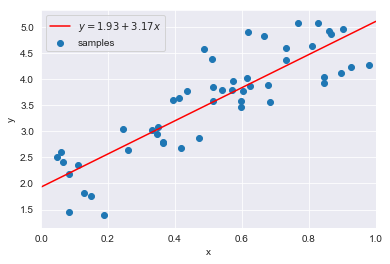

In [4]:
# Implementation of ordinary least squares
X = np.vstack((np.ones_like(x), x)).T

# Fit parameters
Theta = np.linalg.inv(X.T @ X) @ X.T @ y

# Function representing fitted line
f = lambda x: Theta[0] + Theta[1] * x


# Show fitted line
plt.plot([0, 1], [f(0), f(1)], 'r-', 
         label=f'$y = {Theta[0]:.2f} + {Theta[1]:.2f} x$')
plt.scatter(x, y, label='samples')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.xlim((0, 1))
plt.show()

## Gradient descent

The OLS example above might become computationally expensive if we many different variables $\theta_0 \ldots \theta_N$ and many samples $n$. In this case we can resort to [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) to optimise the loss function.

Next we'll show how to optimize with regular [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) which can be made stochastic by braking it down in random batches of size $m < n$.

We're optimizing the same [loss function](https://en.wikipedia.org/wiki/Loss_function) as in OLS:

$$
\hat{\Theta} = \underset{\Theta}{\text{argmin}}{\; \left\Vert Y-X\Theta \right\Vert^2}
$$

Now because we want to minimize this loss function we can just take small steps towards the [minimum](https://en.wikipedia.org/wiki/Maxima_and_minima) of this function, which lies in the oposite direction of the gradient. We saw that the gradient (Jacobian, or derivative) of this loss function was:

$$
\frac{\delta \text{loss}}{\delta \Theta}  = \frac{\delta \left\Vert Y-X\Theta \right\Vert^2}{\delta \Theta} = -2X^T (Y - X\Theta)
$$

This means that if we start out with random parameters $\hat{\Theta}(0)$ we can update these parameters each iteration in the oposite direction of the gradient. Because our loss function in this is [convex](https://en.wikipedia.org/wiki/Convex_function) we should end up at the minimum of our function after a certain amount of steps. One thing we have to make sure that the steps that we take are not to big so that we are not "stepping over" the minmum of our function. We introduce a learning rate parameter $\eta = 0.01$ to prevent this from happening. The parameter update for each iteration $k$ becomes:

$$
\hat{\Theta}(k+1) = \hat{\Theta}(k) - \eta \frac{\delta \text{loss}}{\delta \Theta}
$$

Note that the learning rate $\eta$ is an important parameter that needs to be carefully tuned. If it's too large the solution might never converge, if it's to small the convergence will take a lot of iterations.

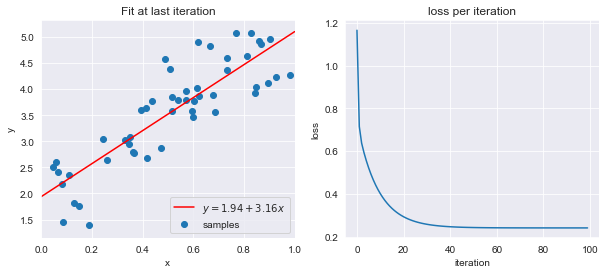

In [5]:
# Implementation of gradient descent
np.random.seed(1)
X = np.vstack((np.ones_like(x), x)).T
# Random initial parameters
Theta = np.random.randn(2)
lr = 0.01  # Learning rate

# Run gradient descent for a number of steps
losses = []  # Will hold the loss (cost) per iteration
for i in range(100):
    grad = - 2 * X.T @ (y - (X @ Theta))  # Compute gradient
    Theta -= grad * lr  # Update paramters
    losses.append(np.mean((y-(X@Theta))**2))  # Compute cost

    
# Function representing fitted line
f = lambda x: Theta[0] + Theta[1] * x


# Show fitted line
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.plot([0, 1], [f(0), f(1)], 'r-', 
         label=f'$y = {Theta[0]:.2f} + {Theta[1]:.2f} x$')
ax1.scatter(x, y, label='samples')
ax1.legend()
ax1.set_title('Fit at last iteration')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_xlim((0, 1))
# Show progression of loss
ax2.plot(losses)
ax2.set_title('loss per iteration')
ax2.set_xlabel('iteration')
ax2.set_ylabel('loss')
plt.show()

## Bayesian linear regression by MCMC

An alternative method to optimizing the likelihood function is to [approximate](https://en.wikipedia.org/wiki/Approximate_Bayesian_computation) the posterior distribution by sampling based on [Markov Chain Monte Carlo (MCMC)](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) methods. One such sampling algorithm is the [Metropolis-Hastings algorithm](https://en.wikipedia.org/wiki/Metropolis–Hastings_algorithm).

Remember that the posterior distribution of $\theta$ given the observed data $x, y$ is defined as:

$$
p(\theta \mid y, x) = \frac{p(y, x \mid \theta)p(\theta)}{p(y, x)}
$$


### Sampling with Metropolis-Hastings

The Metropolis-Hasting algorithm defines a way to create a [Markov chain](https://en.wikipedia.org/wiki/Markov_chain) which has as stationary distribution the posterior $p(\theta \mid y, x)$ we're trying to approximate. What this means that if we sample infinite number of samples from this markov chain the samples should be as if they were sampled from the posterior.

Given an initial guess for parameters $\theta(0)$, the Metropolis-Hastings algorithm works as follows
1. Choose a new proposed value $\theta_p$ by adding random noise the the initial parameters: 
$$
\theta_{p}(k) = \theta(k) + \Delta \theta \quad \text{with}\; \Delta \theta \sim \mathcal{N}(0, \sigma^2)
$$
2. Calculate the ratio: 
$$
\rho = \frac{p(\theta_p(k) \mid y, x)}{p(\theta(k) \mid y, x)} 
= \frac{\frac{p(y, x \mid \theta_p(k)) p(\theta_p(k))}{p(y, x)}}{\frac{p(y, x \mid \theta(k))p(\theta(k))}{p(y, x)}} 
=\frac{p(y, x \mid \theta_p(k))p(\theta_p(k))}{p(y, x \mid \theta(k))p(\theta(k))}
$$
3. if $\rho \geq 1$ then set $\theta(k+1) = \theta_p(k)$. Else if $\rho \lt 1$ set $\theta(k+1) = \theta_p(k)$ with probability $\rho$, otherwise set $\theta(k+1) = \theta(k)$
4. repeat from step 1.

For simplicity we will be ignoring the prior $p(\theta)$ below when calculuting the ratio: 

$$
\rho = \frac{p(y, x \mid \theta_p(k))}{p(y, x \mid \theta(k))}
$$

Adding a prior is simple and means we shoud just multiply an extra term when calculating the ratio $\rho$. We will thus only use the ratio of the likelihood function. We defined these likelhood functions for our problem earlier as:

$$
p(y, x \mid \theta_0, \theta_1) = \prod_{i=1}^{n} p(y_i, x_i \mid \theta_0, \theta_1) = \prod_{i=1}^{n} \frac{1}{\sqrt{2\pi\sigma^2}} e^{\textstyle \left( -\frac{(y_i - (\theta_0 + \theta_1 x_i))^2}{2\sigma^2}\right)}
$$

To avoid numerical underflow when probabilities are small we will be performing the computations in the [log](https://en.wikipedia.org/wiki/Logarithm) space where the multiplications will become additions.

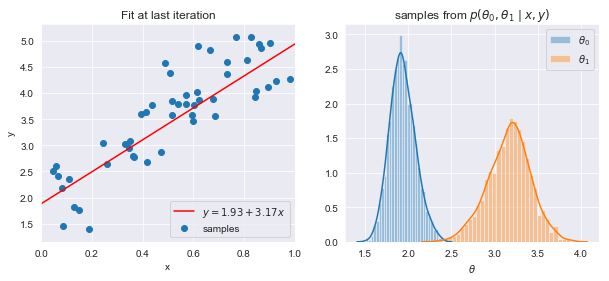

In [6]:
# Implementation of metropolis-Hasting MCMC
np.random.seed(1)

def log_pdf(y, x, theta_0, theta_1, sigma):
    """Log of PDF of likelihood"""
    sigma_sq = sigma**2
    mse = sum((y - (theta_0+theta_1*x)) ** 2)
    return - len(y) * log(sqrt(2*pi*sigma_sq)) \
        - (1./(2*sigma_sq)) * mse

# Theta[0] will be theta_0
# Theta[1] will be theta_1
# Theta[2] will be sigma, which we can't ignore in our sampling
Theta = np.ones(3)  # Initial parameters


# Run Metropolis-Hastings MCMC
n_samples = 10000
samples = []  # List of all samples
for i in range(n_samples):
    dTheta = np.random.randn(3) * 0.1  # Random noise to add to parameter
    Theta_p = Theta + dTheta  # Proposal
    log_ratio = log_pdf(y, x, *Theta_p) - log_pdf(y, x, *Theta)
    if log_ratio >= e:
        # Ratio >= 1: accept proposal
        Theta = Theta_p
        samples.append(tuple(Theta))
    else:
        # Ratio < 1: check with probability == ratio
        if (log(np.random.uniform()) < log_ratio):
            Theta = Theta_p
            samples.append(tuple(Theta))


th_0_samples, th_1_samples, sigma_samples = zip(*samples)
# Compute the mean of the last samples
# The first 1000 samples are ignored because the MCMC has not yet converged
theta_0 = np.mean(th_0_samples[1000:])
theta_1 = np.mean(th_1_samples[1000:])


# Show fitted line
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.plot([0, 1], [f(0), f(1)], 'r-', 
         label=f'$y = {theta_0:.2f} + {theta_1:.2f} x$')
ax1.scatter(x, y, label='samples')
ax1.legend()
ax1.set_title('Fit at last iteration')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_xlim((0, 1))
# Show distribution of theta_0 and theta_1
sns.distplot(th_0_samples[1000:], ax=ax2, label='$\\theta_0$')
sns.distplot(th_1_samples[1000:], ax=ax2, label='$\\theta_1$')
ax2.set_title('samples from $p(\\theta_0, \\theta_1 \\mid x,y)$')
ax2.set_xlabel('$\\theta$')
ax2.legend()
plt.show()